<a href="https://colab.research.google.com/github/aleksandr-del/kaggle-competitions/blob/main/season_3_episode_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Media Campaign Cost Prediction

Данные (обучающая и тестовая выборки) для этого [соревнования](https://www.kaggle.com/competitions/playground-series-s3e11/overview) были сгенерированы нейронной сетью, обученной на исходных данных [Media Campaign Cost Prediction](https://www.kaggle.com/datasets/gauravduttakiit/media-campaign-cost-prediction). Распределения признаков близко к исходным.

У данных следующие признаки:

- `store_sales` - выручка магазина(в миллионах долларов США)
- `unit_sales` - продажи в штуках (в миллионах единиц
- `Total_children` - общее количество детей
- `avg_cars_at home` - среднее количество автомобилей в семье
- `Num_children_at_home` - количество детей в семье
- `Gross_weight` - вес брутто единицы товара
- `Recyclable_package` - упаковка товара пригодна для вторичного использования
- `Low_fat` - низкое содержание жира
- `Units_per_case` - количество единиц товара/упаковок в наличии на полке магазина
- `Store_sqft` - площадь магазина в квадратных футах
- `Coffee_bar` - наличие кофейни в магазине
- `Video_store` - наличие магазина видеоигр
- `Salad_bar` - наличие салад-бара
- `Prepared_food` - наличие готовой еды
- `Florist` - наличие отдела с цветами
- `Cost` - затраты на привлечение клиента в долларах США

## Загрузка и анализ данных

Импортируем необходимые библиотеки и модули:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline 
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor

from tqdm.autonotebook import tqdm

Загрузим обучающую и тестовую выборки:

In [ ]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c playground-series-s3e11

 78% 7.00M/9.00M [00:00<00:00, 72.9MB/s]
100% 9.00M/9.00M [00:00<00:00, 79.0MB/s]


Распакуем архивный файл:

In [ ]:
! unzip playground-series-s3e11.zip -d data

Archive:  playground-series-s3e11.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


Сохраним обучающую выборку в переменной `df` и выведим первые 5 строк:

In [ ]:
df = pd.read_csv('/content/data/train.csv')
df.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


Общая информация об обучающей выборке:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

В обучающей выборке 360 336 наблюдений. 14 признаков. Целевой признак - `cost`. Пропуски отсутствуют. Значения всех признаков - количественные.

В переменной `X` сохраним списков всех признаков, в переменной `y` - целевой признак:

In [ ]:
X = df.drop(columns=['id', 'cost']).columns.to_list()
X

['store_sales(in millions)',
 'unit_sales(in millions)',
 'total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'gross_weight',
 'recyclable_package',
 'low_fat',
 'units_per_case',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist']

In [ ]:
y = 'cost'
y

'cost'

Посмотрим на распределения признаков:

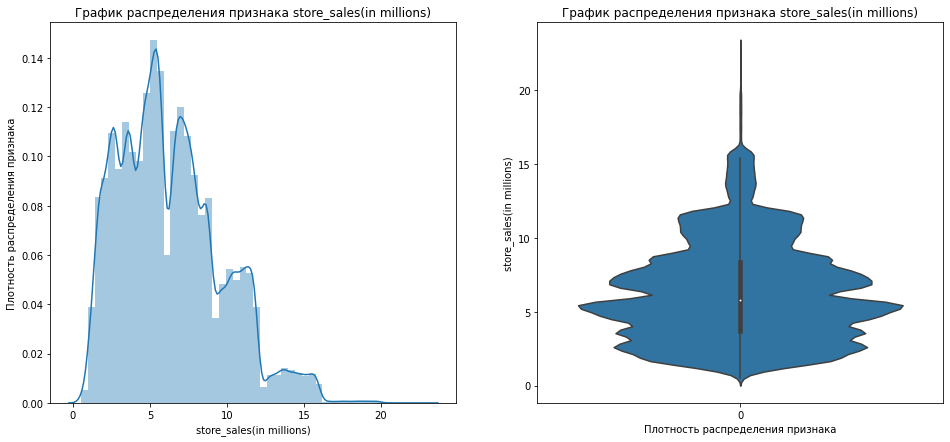

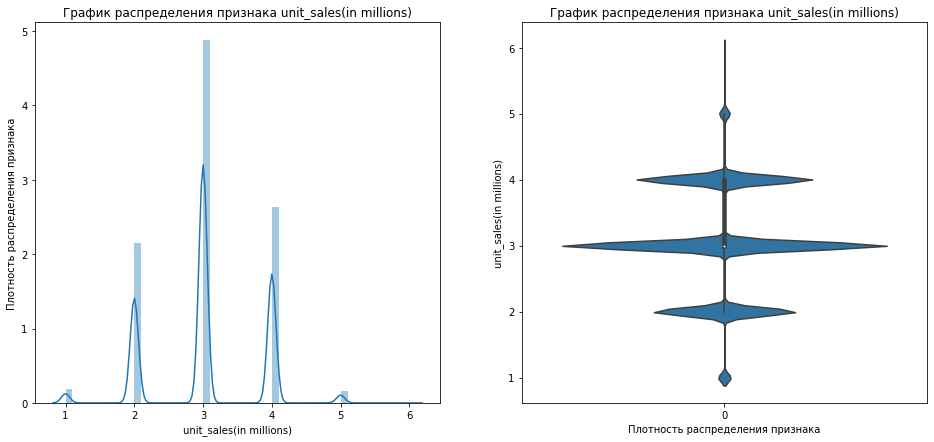

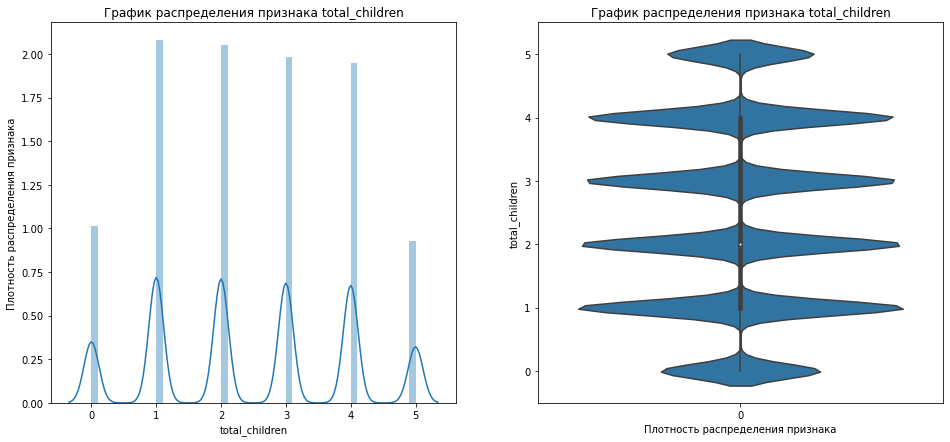

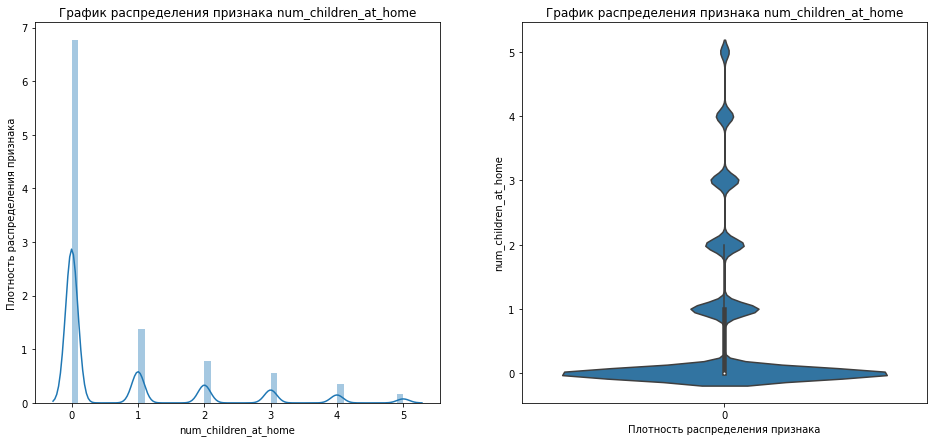

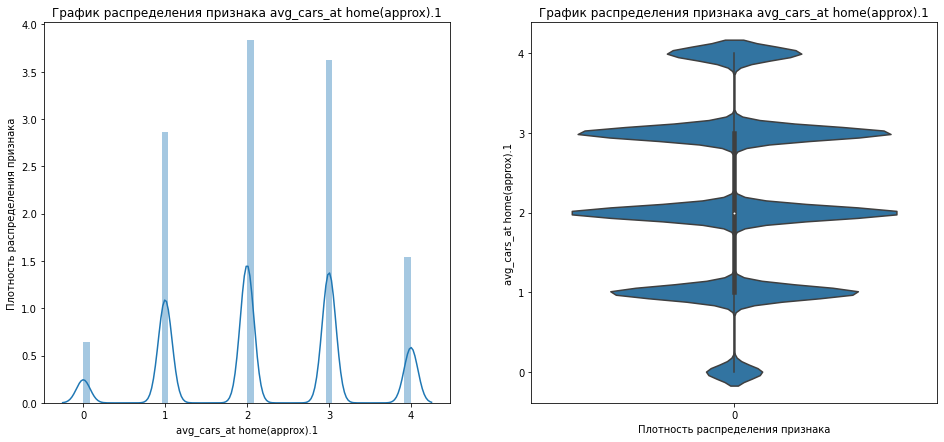

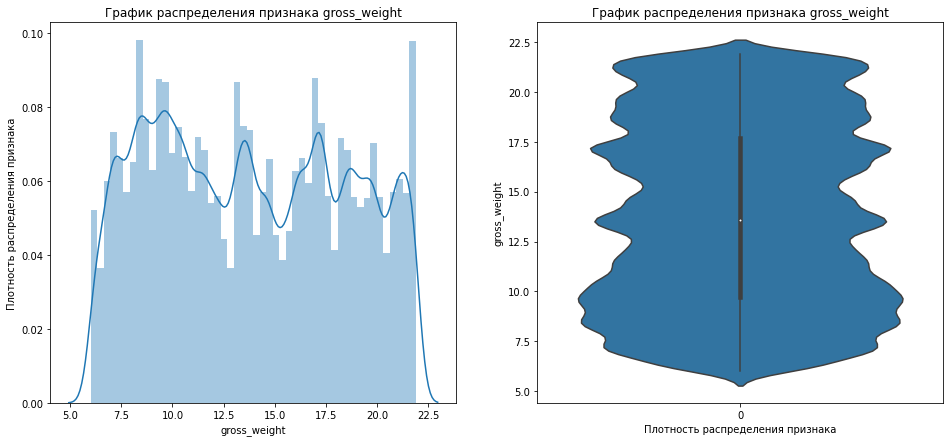

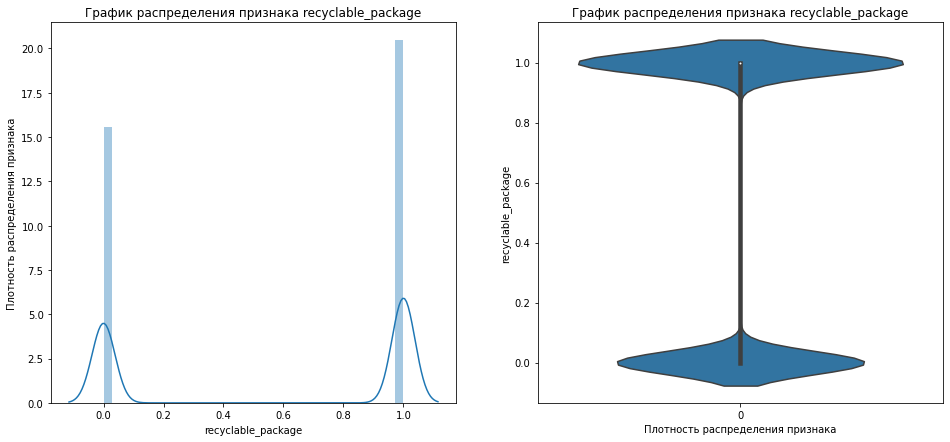

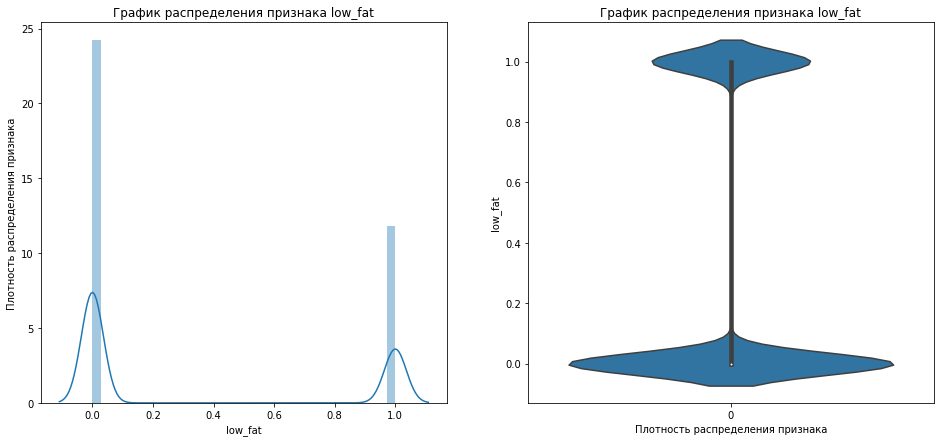

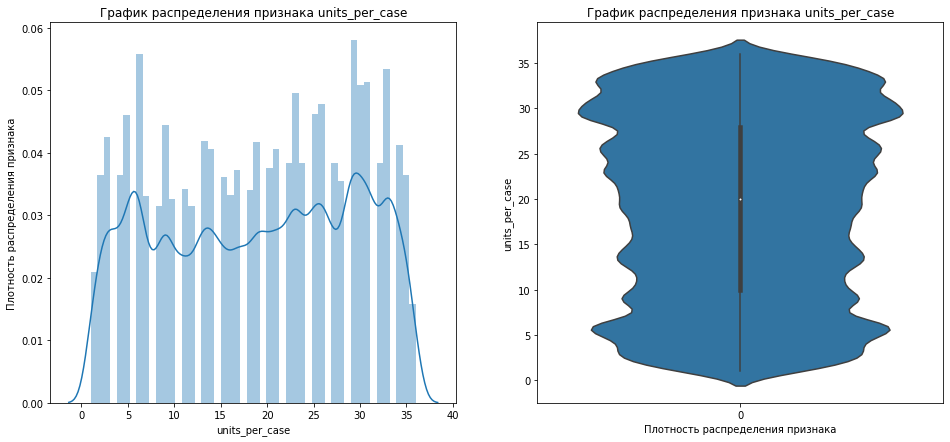

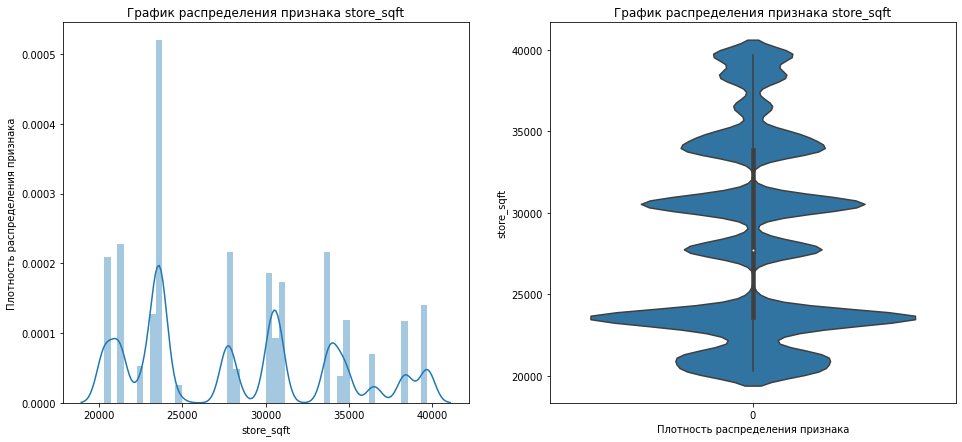

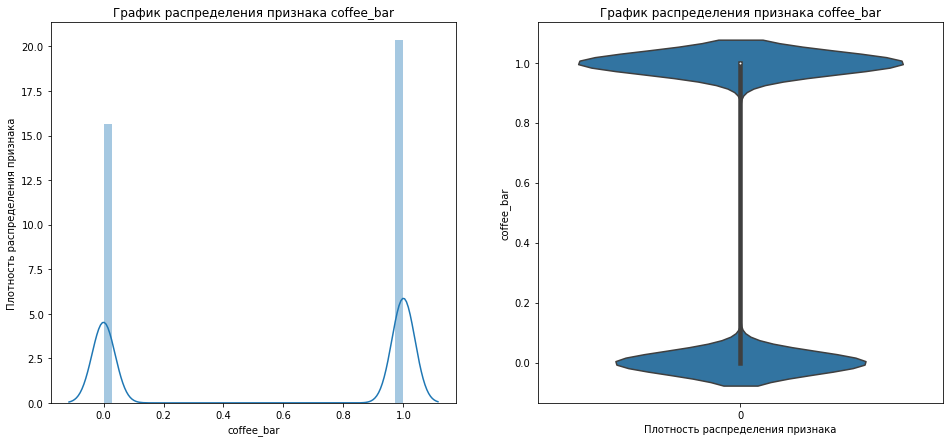

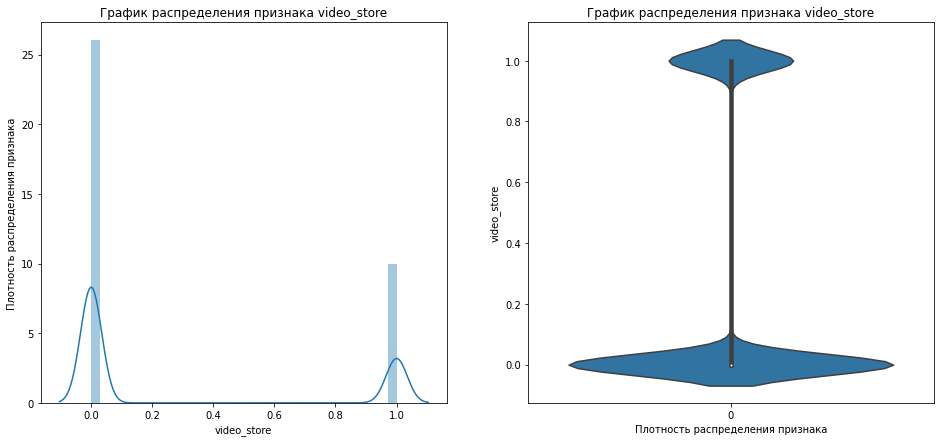

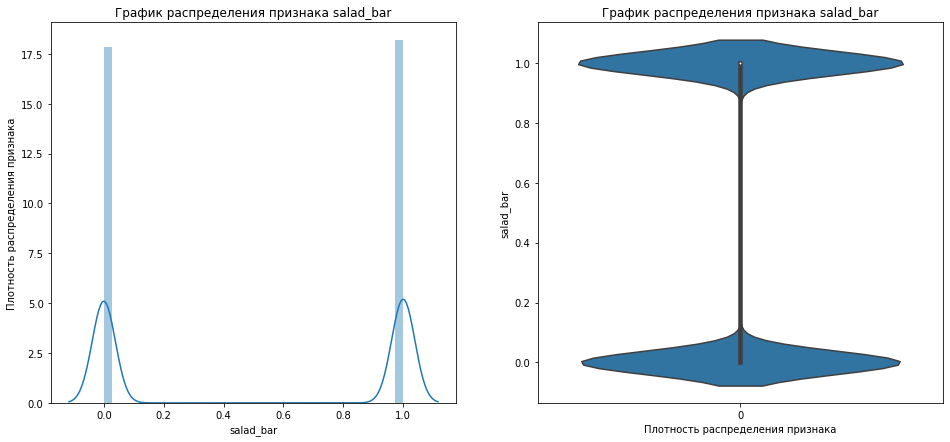

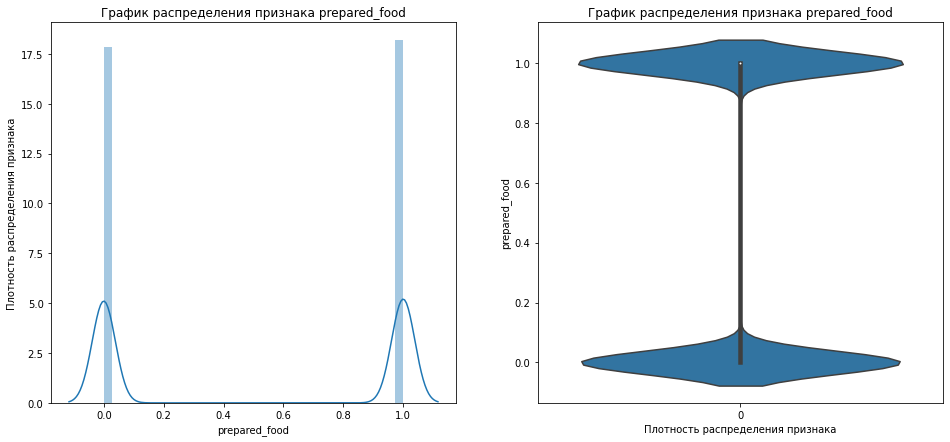

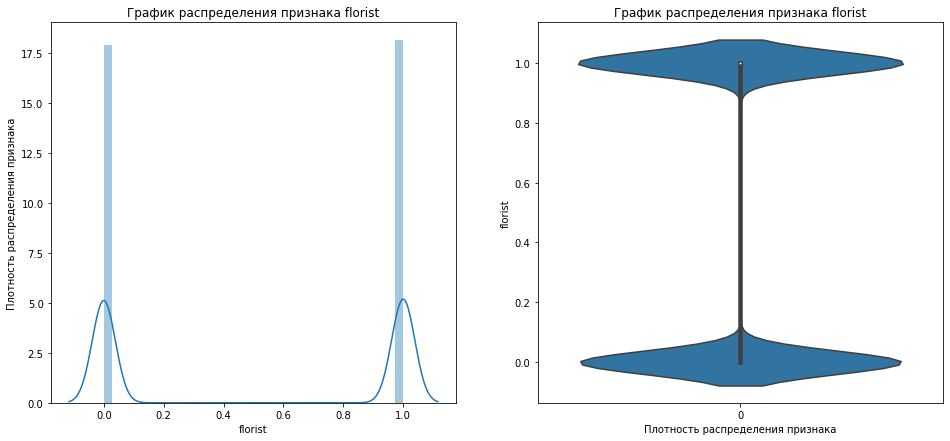

In [ ]:
for i in range(len(X)):
    _, ax = plt.subplots(1, 2, figsize=(16, 7))
    sns.distplot(df[X[i]], ax=ax[0])
    ax[0].set(ylabel='Плотность распределения признака',
              xlabel=f'{X[i]}',
              title=f'График распределения признака {X[i]}')
    sns.violinplot(df[X[i]], ax=ax[1])
    ax[1].set(ylabel=f'{X[i]}',
              xlabel='Плотность распределения признака',
              title=f'График распределения признака {X[i]}')
    plt.show();
    print()

Посмотрим на распределение целевого признака:

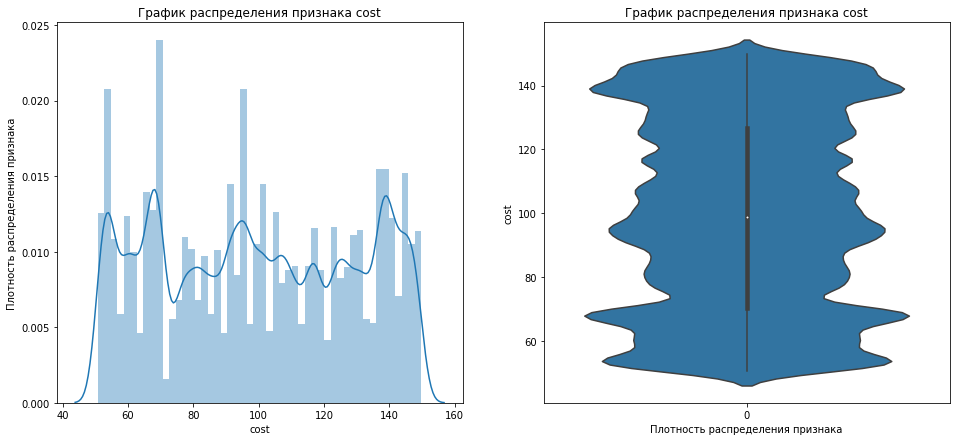

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(16, 7))
sns.distplot(df[y], ax=ax[0])
ax[0].set(ylabel='Плотность распределения признака', 
          xlabel=f'{y}', 
          title=f'График распределения признака {y}')
sns.violinplot(df[y], ax=ax[1])
ax[1].set(ylabel=f'{y}', 
          xlabel='Плотность распределения признака', 
          title=f'График распределения признака {y}')
plt.show();

## Подготовка признаков

Создадим список количественных признаков и сохраним его в переменной `num_features`:

In [ ]:
num_features = ['store_sales(in millions)', 'gross_weight', 'store_sqft']
num_features

['store_sales(in millions)', 'gross_weight', 'store_sqft']

Создадим список категориальных признаков и сохраним его в переменной `cat_features`:

In [ ]:
cat_features = df.drop(columns=['store_sales(in millions)', 'gross_weight', 'store_sqft', 'id', 'cost']).columns.to_list()
cat_features

['unit_sales(in millions)',
 'total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'recyclable_package',
 'low_fat',
 'units_per_case',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist']

Создадим конвейер подготовки количественных признаков. Пропущенные значения, если они есть, будут заполняться медианой, значения признаков будут нормализованы:

In [ ]:
num_transformer = make_pipeline(SimpleImputer(strategy='median'),
                                StandardScaler())

Создадим конвейер подготовки категориальных признаков. Пропущенные значения, если они есть, будут заполняться наиболее часто встречающимся значением, категориальные значения будут преобразованы в числовые:

In [ ]:
cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                OneHotEncoder(handle_unknown='ignore',
                                              sparse=False))

Создадим preprocessor для подготовки всех данных:

In [ ]:
preprocessor = ColumnTransformer([('num', num_transformer, num_features),
                                  ('cat', cat_transformer, cat_features)],
                                 verbose_feature_names_out=False)

## Обучение

### Линейная регрессия с регуляризацией Lasso

Создадим финальный конвейер для подготовки и обучения алгоритма:

In [ ]:
alg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', Lasso(random_state=42))])

Посмотрим на этапы финального конвейера:

In [ ]:
alg

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  ['store_sales(in millions)',
                                                   'gross_weight',
                                                   'store_sqft'],
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())])),
                                                 ('cat',
                                                  ['unit_sales(in millions)',
                                                   'total_children',
                                                   'num_children_at_home',
                                                   'avg_cars_at home(approx).1',
                                                   'recyclable_package',
                                                   'low_fat', 'units_per_case',
                                                   'coffee_bar', 'video_store',
                                                   'salad_bar', 'prepared_food',
                                                   'florist'],
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='no',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]))],
                                   verbose_feature_names_out=False)),
                ('estimator', Lasso(random_state=42))])

Создадим сетку гиперпараметров алгоритма линейной регрессии:

In [ ]:
parameters = {
    'estimator__alpha': [0, 0.01, 0.1, 0.5, 0.7, 1, 2, 5, 10],
    'estimator__max_iter': [300, 500, 1000, 2000, 5000]
}

In [ ]:
lrl = GridSearchCV(alg,
                  parameters,
                  cv=5,
                  scoring='neg_mean_squared_log_error',
                  n_jobs=4)

Обучим алгоритм линейной регрессии:

In [ ]:
lrl.fit(df[X], df[y])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['store_sales(in '
                                                                          'millions)',
                                                                          'gross_weight',
                                                                          'store_sqft']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('oneh...
                                                                          'home(approx).1',
                                                                          'recyclable_package',
                                                                          'low_fat',
                                                                          'units_per_case',
                                                                          'coffee_bar',
                                                                          'video_store',
                                                                          'salad_bar',
                                                                          'prepared_food',
                                                                          'florist'])],
                                                          verbose_feature_names_out=False)),
                                       ('estimator', Lasso(random_state=42))]),
             n_jobs=4,
             param_grid={'estimator__alpha': [0, 0.01, 0.1, 0.5, 0.7, 1, 2, 5,
                                              10],
                         'estimator__max_iter': [300, 500, 1000, 2000, 5000]},
             scoring='neg_mean_squared_log_error')

Лучшие гиперпараметры модели линейной регресии:

In [ ]:
lrl.best_params_

{'estimator__alpha': 0.01, 'estimator__max_iter': 300}

Лучшая метрика RMSLE модели линейной регрессии:

In [ ]:
(-lrl.best_score_) ** 0.5

0.3167230226884902

### Градиентный бустинг

Реализуем класс градиентного бустинга:

In [ ]:
class MyGradientBoosting():
    def __init__(self, lr=0.01, iters=1000, max_depth=32):
        self.lr = lr
        self.iters = iters
        self.max_depth = max_depth
        self.models_ = None
        self.constant_prediction_ = None
        self.RMSLE_ = None

    def fit(self, X, y):
        X = X.values
        y = y.values
        prediction = np.full((y.shape), np.mean(y)) # инициализируем модель константным предсказанием: среднее значение таргета обучающей выборки
        models = [] # в этом списке будем хранить модели Решающего дерева
        RMSLE = [] # в этом списке будем хранить значение MSE каждой итерации

        for _ in range(self.iters):
            residual = y - prediction # считаем остатки
            model = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42) # инициализируем модель Решающего дерева
            model.fit(X, residual) # обучаемся на остатках
            prediction += model.predict(X) * self.lr # корректируем константное предсказание, компенсируя остатки
            models.append(model) # сохраняем модель в список моделей
            RMSLE.append(mean_squared_log_error(y, prediction, squared=False)) # сохраняем метрику MSE
           
        self.models_ = models
        self.constant_prediction_ = np.mean(y)
        self.RMSLE_ = RMSLE

    def predict(self, X):
        X = X.values
        prediction = np.full((X.shape[0]), self.constant_prediction_)

        for model in self.models_:
            prediction += model.predict(X) * self.lr
    
        return prediction

Подготовим данные обучающей выборки и сохраним их в переменной `prep_df`:

In [ ]:
prep_df = pd.DataFrame(preprocessor.fit_transform(df[X]))

Кросс-валидацию градиентного бустинга проведем с помощью `KFold`, дополнительно будем перебирать гиперпараметр `max_depth` (глубина дерева), количество итераций - 500:

In [ ]:
cv = KFold(n_splits=5)

for depth in tqdm([8, 16]):
    RMSLE = []
    for train_index, valid_index in cv.split(prep_df):
        mgb = MyGradientBoosting(max_depth=depth, iters=500, lr=0.01)
        X_train, y_train = prep_df.loc[train_index], df[y].reset_index(drop=True).loc[train_index]
        X_valid, y_valid = prep_df.loc[valid_index], df[y].reset_index(drop=True).loc[valid_index]
    
        mgb.fit(X_train, y_train)
        pred_valid = mgb.predict(X_valid)
        RMSLE.append(mean_squared_log_error(y_valid, pred_valid, squared=False))
        
    print(f'Глубина деревьев: {depth}. RMSLE: {np.mean(RMSLE)}.')

  0%|          | 0/2 [00:00<?, ?it/s]

Глубина деревьев: 8. RMSLE: 0.30106131868097774.
Глубина деревьев: 16. RMSLE: 0.3047059489915014.


## Выбор лучшей модели

#### Лучшая метрика RMSLE у модели градиентного бустинга с глубиной каждого дерева последовательности, равной 8.

Обучим алгоритм градиентного бустинга на всей обучающей выборке:

In [ ]:
best_model = MyGradientBoosting(max_depth=8, iters=3500, lr=0.01)

In [ ]:
best_model.fit(prep_df, df[y])

Визуализируем, как улучшалась метрика RMSLE на обучающей выборке с каждой последующей итерацией:

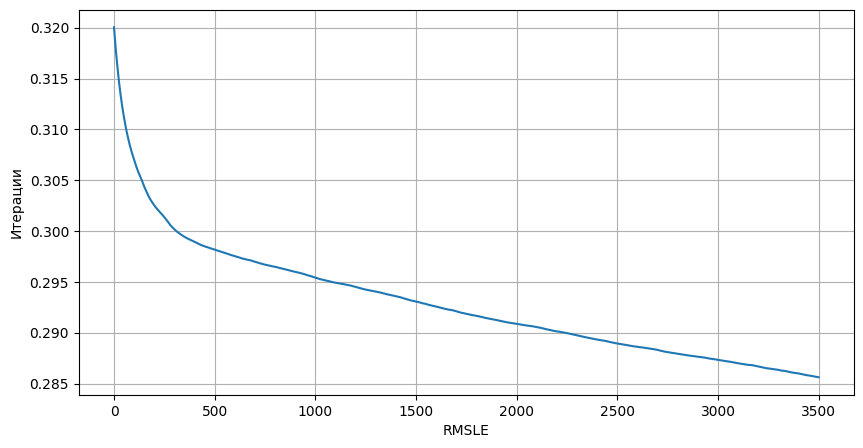

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(best_model.RMSLE_)
plt.grid(True)
plt.xlabel('RMSLE')
plt.ylabel('Итерации')
plt.show()

## Submission для соревнования

Сохраним тестовую выборку в переменную `test`:

In [ ]:
test = pd.read_csv('/content/data/test.csv')

Выведим первые 5 строк тестовой выборки:

In [ ]:
test.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
0,360336,7.24,4.0,1.0,0.0,2.0,10.80,0.0,1.0,7.0,20319.0,0.0,0.0,0.0,0.0,0.0
1,360337,6.90,2.0,2.0,2.0,3.0,8.51,1.0,0.0,4.0,33858.0,1.0,0.0,1.0,1.0,1.0
2,360338,8.34,3.0,0.0,0.0,3.0,8.77,0.0,1.0,14.0,39696.0,0.0,0.0,1.0,1.0,0.0
3,360339,5.48,2.0,3.0,3.0,2.0,21.90,1.0,0.0,9.0,23688.0,1.0,1.0,1.0,1.0,1.0
4,360340,4.80,3.0,2.0,0.0,2.0,10.90,1.0,0.0,11.0,27694.0,1.0,1.0,1.0,1.0,1.0


Общая информация:

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240224 entries, 0 to 240223
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          240224 non-null  int64  
 1   store_sales(in millions)    240224 non-null  float64
 2   unit_sales(in millions)     240224 non-null  float64
 3   total_children              240224 non-null  float64
 4   num_children_at_home        240224 non-null  float64
 5   avg_cars_at home(approx).1  240224 non-null  float64
 6   gross_weight                240224 non-null  float64
 7   recyclable_package          240224 non-null  float64
 8   low_fat                     240224 non-null  float64
 9   units_per_case              240224 non-null  float64
 10  store_sqft                  240224 non-null  float64
 11  coffee_bar                  240224 non-null  float64
 12  video_store                 240224 non-null  float64
 13  salad_bar     

Преобразуем данные тестовой выборки:

In [ ]:
prep_test = pd.DataFrame(preprocessor.transform(test[X]))

Предсказание модели градиентного бустинга на тестовой выборке:

In [ ]:
y_test = best_model.predict(prep_test)

Запишем предсказания в столбец `cost`:

In [ ]:
test['cost'] = y_test

Запишем таблицу в файл для отправки решения на Kaggle:

In [ ]:
test[['id', 'cost']].to_csv('submission.csv', index=None)

### Результаты соревнования

#### Соревнование завершено 04 апреля 2023 г. 561 место из 952 с итоговым score =`0.30035`. Score лидера соревнования =`0.29322`.